In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
from data_loader import download_stock_data, save_to_csv
from feature_engineering import add_basic_features
from model import train_model


In [2]:
df = download_stock_data("AAPL", "2018-01-01", "2023-12-31")
save_to_csv(df, "../data/AAPL.csv")
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2018-01-02,40.479839,40.489241,39.774861,39.986357,102223600
1,2018-01-03,40.472786,41.017971,40.409341,40.543284,118071600
2,2018-01-04,40.660786,40.764183,40.437543,40.545638,89738400
3,2018-01-05,41.123718,41.210664,40.665483,40.757130,94640000
4,2018-01-08,40.970985,41.267075,40.872285,40.970985,82271200


In [3]:
df = add_basic_features(df)
df.head()


Price,Date,Close,High,Low,Open,Volume,Return,MA_5,MA_10
9,2018-01-16,41.403358,42.155334,41.391608,41.805194,118263600,-0.005082,41.226170,40.983897
10,2018-01-17,42.087185,42.122432,41.140165,41.393954,137547200,0.016516,41.450355,41.144631
11,2018-01-18,42.124783,42.322179,41.887441,42.150632,124773600,0.000893,41.683936,41.309831
12,2018-01-19,41.936806,42.199996,41.690063,41.972053,129700400,-0.004462,41.833395,41.437433
13,2018-01-22,41.593708,41.777002,41.499712,41.664207,108434400,-0.008181,41.829168,41.484432


In [4]:
model, X_test, y_test, y_pred, rmse = train_model(df)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 8.174028653592504


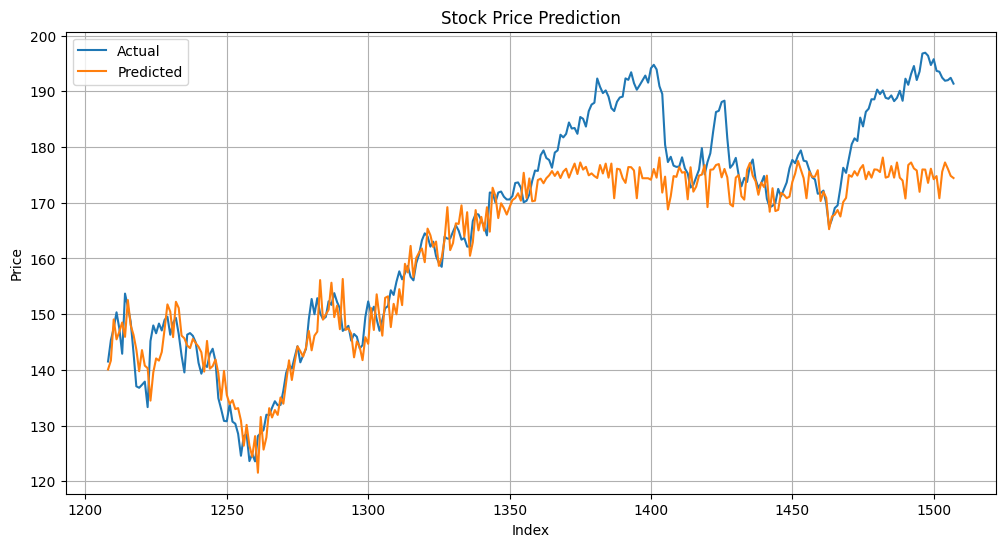

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Stock Price Prediction")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.savefig("../plots/aapl_forecast.png")
plt.show()
